In [91]:
import numpy as np
import pandas as pd
import pandas_datareader.data as web
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from math import sqrt
import  pylab as pl

D = 400
rf = 0 #Risk free return

date_D_days_ago = datetime.now() - timedelta(days=D)
now = datetime.now()

start_date = date_D_days_ago.strftime('%F')
end_date = now.strftime('%F')

#Fortmat output
pct = lambda x: '{:.2%}'.format(x)
dig = lambda x: '{:.2f}'.format(x)



# Max Sharpe with Min correlation
def MaxSharpe_MinCorr(new_df, sharpe, asset, num):
    sharpe = sharpe.drop(asset)    
    max_sharpe = sharpe.sort_values(ascending = False).head(num)
    list_max = np.array(max_sharpe.index.values)
    porfolio_A = new_df[list_max].corrwith(new_df[asset]).abs().sort_values(ascending = True).head(9)  
    porfolio_A = pd.Series(porfolio_A.index.values)
    return porfolio_A

# Min correlation with Max Sharpe
def MinCorr_MaxSharpe(new_df, asset, num):
    porfolio_B = new_df.corrwith(new_df[asset]).abs().sort_values(ascending = True).head(num)
    new_df = new_df[porfolio_B.index.values]
    f_sharpe = (250**0.5)*(new_df.mean()/new_df.std())    
    f_sharpe.sort_values(ascending = False)
    max_sharpe = f_sharpe.head(9)
    porfolio_B = pd.Series(max_sharpe.index.values)
    return porfolio_B


# Pofolio Optimization and Efficient Frontier (TO REVIEW)
def P_Optimization(df):
    ind_er = df.pct_change().apply(lambda x: np.log(1+x)).mean().apply(lambda x: x*250)
    cov_matrix = df.pct_change().apply(lambda x: np.log(1+x)).cov()
    corr_matrix = df.pct_change().apply(lambda x: np.log(1+x)).corr()
    ann_sd = df.pct_change().apply(lambda x: np.log(1+x)).std().apply(lambda x: x*np.sqrt(250))

    p_ret = [] # Define an empty array for portfolio returns
    p_vol = [] # Define an empty array for portfolio volatility
    p_weights = [] # Define an empty array for asset weights

    num_assets = len(df.columns)
    num_portfolios = 10000
    
    for portfolio in range(num_portfolios):
        weights = np.random.random(num_assets)
        weights = weights/np.sum(weights)
        weights= weights.round(2)
        p_weights.append(weights)
        returns = np.dot(weights, ind_er) # Returns are the product of individual expected returns of asset and its 
                                      # weights 
        p_ret.append(returns)
        var = cov_matrix.mul(weights, axis=0).mul(weights, axis=1).sum().sum()# Portfolio Variance
        sd = np.sqrt(var) # Daily standard deviation
        ann_sd = sd*np.sqrt(250) # Annual standard deviation = volatility
        p_vol.append(ann_sd)
    
    data = {'Returns':p_ret, 'Volatility':p_vol}

    for counter, symbol in enumerate(df.columns.tolist()):
        #print(counter, symbol)
        data[symbol+' weight'] = [w[counter] for w in p_weights]

    portfolios  = pd.DataFrame(data) #Dataframe of the 10000 portfolios created
    return portfolios

def Plot_P_Optimization(porfolios,price):
        min_vol_port = portfolios.loc[portfolios['Volatility'].idxmin()]
        optimal_risky_port = portfolios.loc[((portfolios['Returns']- rf)/portfolios['Volatility']).idxmax()]
        ann_mean = price.pct_change().apply(lambda x: np.log(1+x)).mean().apply(lambda x: x*250)
        ann_std = price.pct_change().apply(lambda x: np.log(1+x)).std().apply(lambda x: x*np.sqrt(250))
              
        # Plotting optimal portfolio
    #    portfolios.plot.scatter(x='Volatility', y='Returns', marker='o', s=10, alpha=0.3, grid=True, figsize=[10,10])
        plt.subplots(figsize=(10, 10))
        plt.scatter(portfolios['Volatility'], portfolios['Returns'], marker='o', s=10, alpha=0.3)
        plt.xlabel('Volatility', fontsize=20)
        plt.ylabel('Returns', fontsize=20)
        plt.scatter(min_vol_port[1], min_vol_port[0], color='r', marker='*', s=400, label='Minimum volatility')
        plt.legend(loc='upper left', fontsize=12)
        plt.scatter(optimal_risky_port[1], optimal_risky_port[0], color='g', marker='*', s=400, label='Maximum Sharpe ratio')
        plt.legend(loc='best', fontsize=12)
                
        #Plotting individual assets
        for i in price.columns:
            plt.scatter(ann_std[i], ann_mean[i], color='b' , marker='.', s=500)
            plt.annotate('   '+i, (ann_std[i], ann_mean[i]), ha='left', va='center')
    
         #Saving plots to use them later    
        plt.savefig('data/img/'+s+'_optimal_porfolio.png')
        plt.cla()
        plt.close('all')
        #return 

#K-Means Clustering
def Clustering(ann_mean, ann_std):
        ret_var = pd.concat([ann_mean, ann_std], axis = 1).dropna()
        ret_var.columns = ["Return","Volatility"]

        X =  ret_var.values #Converting ret_var into nummpy arraysse = []for k in range(2,15):
        df = pd.DataFrame(X, index=ret_var.index, columns=['X','Y'])
        #pl.scatter(X[:,1],X[:,0], c = kmeans.labels_, cmap ="rainbow")
        #plt.scatter(centroids[:,1],centroids[:,0], marker = 'x', color = 'b', label = 'Centroids')
        kmeans = KMeans(n_clusters = 5).fit(X)
        centroids = kmeans.cluster_centers_
        cluster_labels = pd.DataFrame(kmeans.labels_, index=ret_var.index, columns=['Clustering'])
        #tupper = pd.concat([tupper, cluster_labels],axis = 1)
        print ('Builing Clustering with the ML Library K-Means') 
        return cluster_labels
    
    
#Performace for each stock
def Performance(p):
    window = ['D','W','M','3M','6M','A']
    perform = pd.DataFrame(0, index = p.columns, columns=window)

    for i in window:    
        df = p.resample(i).last().pct_change().tail(2)
        perform[i] = df.iloc[0,:].apply(pct) 
    
    df = p.resample('Y').last().pct_change().tail(1)
    perform['YTD'] = df.iloc[0,:].apply(pct)
    
    return perform
    
# Read industry and sectors of stock market
info = pd.read_csv('data/S&P500-Info.csv', index_col=['Symbol'])
info = pd.DataFrame(info)



custom_date_parser = lambda x: datetime.strptime(x,"%Y-%m-%d")
price = pd.read_csv('data/price.csv', index_col=['Date'], parse_dates=['Date'], date_parser=custom_date_parser)
price = pd.DataFrame(price)

# Read  Tickers
tickers = price.columns



# Expected annualized Return, Volatility, Correlation and Sharpe
ann_mean = price.pct_change().apply(lambda x: np.log(1+x)).mean().apply(lambda x: x*250)
ann_std = price.pct_change().apply(lambda x: np.log(1+x)).std().apply(lambda x: x*np.sqrt(250))
corr = price.pct_change().apply(lambda x: np.log(1+x)).corr()
cov  = price.pct_change().apply(lambda x: np.log(1+x)).cov()
Sharpe = (ann_mean - rf)/ann_std
perform_df = Performance(price)



# Building Tupperware
tupper = pd.DataFrame(ann_mean, columns=['Return'], index = tickers)
tupper.index.name = 'ticker'
tupper ['Volatility'] = pd.DataFrame(ann_std, columns=['Volatility'])
tupper ['Sharpe'] = pd.DataFrame(Sharpe, columns=['Sharpe'])
tupper ['Min_Corr'] = pd.DataFrame(corr.abs().idxmin(), columns=['Min_Corr'])
tupper ['Corr_value'] = pd.DataFrame(corr.min(), columns=['Corr_Value'])
tupper['Return'] = tupper['Return'].apply(pct)
tupper['Volatility'] = tupper['Volatility'].apply(pct)
tupper['Sharpe'] = tupper['Sharpe'].apply(dig)


#cluster_labels = Clustering(ann_mean, ann_std)
tupper = pd.concat([tupper, perform_df],axis = 1)



tupper.to_csv('data/tupper_'+end_date+'.csv')
print ('DataFrame built')  


DataFrame built


In [64]:
#tupper[tupper['Clustering']==4].sort_values(by='Sharpe',ascending = False).head(5)

tupper_now = pd.read_csv('data/tupper_'+end_date+'.csv', index_col='ticker')

portfolio = ['NIO','PTON','TSLA']


if tupper.index.isin(['AA']).any() ==True:
    print('AA')
    

In [65]:

portfolio_df= pd.DataFrame(0, columns = ['a0','a1','a2','a3','a4','a5','a6','a7','a8','a9'], index = tickers)                                            
portfolio_df['a0'] = portfolio_df.index.values

min_vol_port_df = pd.DataFrame(0, columns = ['mv_Returns','mv_Volatility','mv_w0','mv_w1','mv_w2','mv_w3','mv_w4','mv_w5','mv_w6','mv_w7','mv_w8','mv_w9'], index = sp500)
optimal_risky_port_df = pd.DataFrame(0, columns = ['or_Returns','or_Volatility','or_w0','or_w1','or_w2','or_w3','or_w4','or_w5','or_w6','or_w7','or_w8','or_w9'], index = sp500)
    


#Building porfolios 
for r in portfolio_df.index.values:
    Test_A = MaxSharpe_MinCorr(price, Sharpe, r, 100)
    for c in range(9):
        portfolio_df.loc[r,'a'+str(c+1)] = Test_A[c]
         
ti = 0
    
for s in portfolio_df.index.values:
    p = price[portfolio_df.loc[s,:]]
    ti = ti +1
    portfolios = P_Optimization (p)
    min_vol_port = portfolios.loc[portfolios['Volatility'].idxmin()]
    optimal_risky_port = portfolios.loc[((portfolios['Returns']- rf)/portfolios['Volatility']).idxmax()]
    print('Porfolio '+str(ti)+' optimized.')
              
    # Plotting optimal portfolio
    #portfolios.plot.scatter(x='Volatility', y='Returns', marker='o', s=10, alpha=0.3, grid=True, figsize=[10,10])
    #Plot_P_Optimization(portfolios,p)
        
    #Saving optimal porfolios weights in a DataFrame
    min_vol_port_df.loc[s,:]  = min_vol_port.values
    optimal_risky_port_df.loc[s,:] = optimal_risky_port.values
    
   
print('\n Porfolio creation ='+str(ti)) 

#Saving data
tupper = pd.concat([tupper,info,portfolio_df,min_vol_port_df,optimal_risky_port_df], axis=1)
tupper.to_csv('data/tupper_'+end_date+'.csv')

print ('Done! /n Tupperware Data created on '+end_date)

NameError: name 'sp500' is not defined

In [75]:

p = price.loc[:,['TSLA','CSCO']]    

In [81]:
df = Performance(p)

df

,D,W,M,3M,6M,A,YTD
TSLA,-2.14%,2.48%,24.33%,64.49%,226.76%,743.44%,19.78%
CSCO,0.97%,-1.45%,4.02%,14.66%,-2.40%,-3.49%,3.03%


In [110]:
import altair as alt

df = cluster_labels

alt.Chart(df).mark_bar().encode(
    x='value:N',
    y='count():Q'
)

alt.Chart(...)

In [112]:
cluster_labels.values.partic

<function ndarray.argpartition>

Populating the interactive namespace from numpy and matplotlib


/Users/datapro/opt/anaconda3/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['info', 'f', 'datetime', 'sqrt', 'cov']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


<module 'matplotlib.pyplot' from '/Users/datapro/opt/anaconda3/lib/python3.8/site-packages/matplotlib/pyplot.py'>

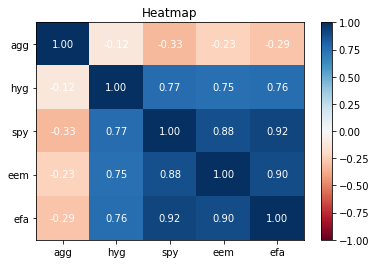

In [14]:
%pylab inline

returns.plot_corr_heatmap()



In [174]:
US_index = ['^GSPC','^IXIC']
gold = 'GC=F'
oil  = 'CL=F'
bitcoin = 'BTC-USD'

In [73]:
cluster_labels.


SyntaxError: invalid syntax (<ipython-input-73-c2d6bda2dda6>, line 1)

In [81]:

#tupper[tupper['Clustering']==4].sort_values(by='Sharpe',ascending = False).head(5)


tupper_now = pd.read_csv('data/tupper_'+end_date+'.csv', index_col='ticker')

portfolio = ['NIO','PTON','TSLA']

df = tupper.iloc[:,[0,1]]

if df.index.isin(['TSLA']).any() == True:
    
else:
    df.append()


Esto


In [72]:
df.append(df2)

,Exp Return,Volatility,Sharpe,Min_Corr,Corr_value
ticker,,,,,
MMM,0.082392,0.367006,0.224497,VNT,0.063177
ABBV,0.200927,0.343440,0.585044,NEM,0.121352
ABMD,0.712941,0.458253,1.555781,KR,0.054239
ACN,0.169539,0.400641,0.423168,KR,0.201943
ATVI,0.402349,0.379823,1.059306,OTIS,-0.087953
...,...,...,...,...,...
YUM,0.033956,0.418083,0.081218,CLX,-0.027267
ZBRA,0.400108,0.481007,0.831813,NEM,0.157344
ZBH,0.051616,0.480893,0.107334,CPB,-0.083091
